# EXERCISE 6.5: Predicting carbon stock

---

**Use of Earthpy with Rwanda geodata and scikitlearn to train a linear regression model to predict carbon stock**

Accurate carbon storage estimation is essential for monitoring the impact of deforestation, land degradation, and land restoration programs on carbon sequestration. In this exercise we will use a Sentinel-2 image of Rwamagana and the product obtained during EDA exercise to predict carbon-stock. We will follow the following steps:

1. Preprocessing: This includes all processes we conducted during EDA exercise (resampling the image and stacking).
2. Data collection: Collect ground truth data on above ground biomass for a representative sample of the study area.
3. Feature extraction: Extract relevant features from the preprocessed Sentinel-2 image that are correlated with carbon stock. This will use spectral indices such as the Normalized Difference Vegetation Index (NDVI), vegetation indices such as the Enhanced Vegetation Index (EVI), and other indices such as the Soil-Adjusted Vegetation Index (SAVI) extracted during EDA exercise.
4. Model selection: Select a suitable machine learning model for the task of predicting above ground biomass. Common models include Random Forest, Support Vector Machine (SVM), and Gradient Boosting Machine (GBM).
Model training: Train the selected model on the extracted features and ground truth data.
5. Model evaluation: Evaluate the performance of the trained model on a validation dataset.
Model tuning: If the performance of the model is not satisfactory, we will tune the hyperparameters of the model using techniques such as grid search.
6. Prediction: Use the trained model to predict carbon-stock for the entire study area. This will result in a raster dataset.

Dependancy packages are installed as  <code>
    !pip install module name or package name </code>

In [1]:
#This is how we install libraries in Colab
!pip install earthpy plotly matplotlib geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 36.7 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
from glob import glob
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import rasterio
from rasterio.plot import show
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from skimage.transform import resize
import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## DataSet from previous EDA Exercise
Rwamagana Satellite Data

In Colab, we need first to connect/mount it to the google drive/ which is a place where we are sourcing our data. This will open a dialogue box asking for authorization to access your google drive. Click 'Connect to Google Drive', then select the account where you uploaded this notebook and click 'Allow' to proceed.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make sure the path provide below is correct as per your colab setup. If you have uploaded directly to your google drive and opened the notebook file, then this path should work.

Now let's import some image data from the exercise data folder:

In [4]:
#Open the image file using rasterio and see its shape
#Adjust the directory accordingly
with rio.open('/content/drive/MyDrive/ML4EO/Excercise 2/data/stacked_data.tif') as src:
    # Get the number of bands in the image
    stacked_data = src.read()
    # Get the metadata (profile) of the stack file
    profile = src.profile
    num_bands = src.count
    print(src.crs)

EPSG:32735


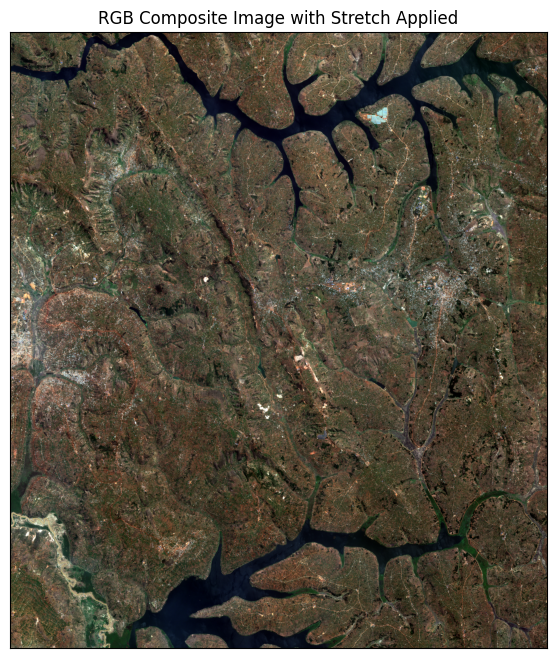

In [ ]:
#Let  plot RGB composite images with stretch to make it more clear
ep.plot_rgb(
    stacked_data,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(10, 8),
    title="RGB Composite Image with Stretch Applied",
)

plt.show()

## Ground Truth Data collection

The ground truth data foor carbon stock was extracted from the study ["Nation-wide mapping of tree-level aboveground carbon stocks in Rwanda"](https://www.nature.com/articles/s41558-022-01544-w). Data can be accessed from [here](https://zenodo.org/record/7118176#.ZFvBUy9BxQI).

In [ ]:
# Open the raster file
#adjust directory accordingly
with rio.open('/content/drive/MyDrive/ML4EO/Excercise 2/data/carbon_stock.tif') as src:
    # Read the image into a numpy array
    carbon_stock = src.read()
    # Get the metadata (profile) of the stack file
    profile = src.profile
    # Get the CRS of the raster
    crs = src.crs
    print("CRS:", crs)
    
# Plot the image using earthpy
ep.plot_bands(carbon_stock[0], cmap='gray', figsize=(10, 8), title='Carbon Stock')

In [ ]:

# Randomly sample a subset of the carbon stock dataset since it is bigger
sample_size = 10000
sample_indices = np.random.choice(carbon_stock.size, size=sample_size, replace=False)
sampled_carbon_stock = carbon_stock.flatten()[sample_indices].reshape(-1, 1)


# Feature extraction

Extract relevant features from the preprocessed Sentinel-2 image that are correlated with above ground biomass. This will use spectral indices such as the Normalized Difference Vegetation Index (NDVI), vegetation indices such as the Enhanced Vegetation Index (EVI), and other indices such as the Soil-Adjusted Vegetation Index (SAVI) extracted during EDA exercise. 

**Normalized Difference Vegetation Index (NDVI)**




In [ ]:
# Select the Near-Infrared (NIR) and Red channels
nir = stacked_data[7,:,:]
red = stacked_data[3,:,:]

# Normalize the pixel values to [0, 1]
nir_norm = nir.astype(np.float32) / np.iinfo(nir.dtype).max
red_norm = red.astype(np.float32) / np.iinfo(red.dtype).max

# Compute the NDVI
ndvi = (nir_norm - red_norm) / (nir_norm + red_norm)

# Normalize the NDVI values to [0, 1]
ndvi_norm = (ndvi - np.nanmin(ndvi)) / (np.nanmax(ndvi) - np.nanmin(ndvi))


# Plot the NDVI image using EarthPy's plot_bands() function
ep.plot_bands(ndvi_norm, cmap='RdYlGn', cols=1, figsize=(10, 8), title='Normalized Difference Vegetation Index (NDVI)')

# Show the plot
plt.show()


**Soil-Adjusted Vegetation Index (SAVI)** 

In [ ]:
L = 0.5
savi = ((nir_norm - red_norm) / (nir_norm + red_norm + L)) * (1 + L)
#normalize to scale from 0 to 1
savi_norm = (savi - np.nanmin(savi)) / (np.nanmax(savi) - np.nanmin(savi))



## Question 6.5.1
Use earthpy to plot Soil-Adjusted Vegetation Index (SAVI) on a figure size of (10,8). Do that by completing the code line below:

In [ ]:
ep.plot_bands(<FILL-IN HERE>)

<FILL-IN HERE>

**Visible Atmospherically Resistant Index (VARI)**


In [ ]:
# Select the Red (R), Green (G) and Blue (B) channels
red = stacked_data[3,:,:]
green = stacked_data[2,:,:]
blue = stacked_data[1,:,:]

# Normalize the pixel values to [0, 1]
green_norm = green.astype(np.float32) / np.iinfo(green.dtype).max
red_norm = red.astype(np.float32) / np.iinfo(red.dtype).max
blue_norm = blue.astype(np.float32) / np.iinfo(blue.dtype).max

# Compute the VARI
vari = (green_norm - red_norm) / (green_norm + red_norm - blue_norm)

# Normalize the VARI values to [0, 1]
vari_norm = (vari - np.nanmin(vari)) / (np.nanmax(vari) - np.nanmin(vari))

ep.plot_bands(vari_norm, cmap='RdYlGn', cols=1, figsize=(10, 8), title='Visible Atmospherically Resistant Index (VARI)')

plt.show()

**Normalized Difference Moisture Index (NDMI)**


In [ ]:
# Select the Red (R), Green (G) and Blue (B) channels
nir = stacked_data[7,:,:]
swir1 = stacked_data[10,:,:]

# Normalize the pixel values
nir_norm = nir.astype(np.float32) / np.iinfo(nir.dtype).max
swir1_norm = swir1.astype(np.float32) / np.iinfo(swir1.dtype).max

# Compute the NDMI
ndmi = (nir_norm - swir1_norm) / (nir_norm + swir1_norm)

# Normalize the NDMI values to [0, 1]
ndmi_norm = (ndmi - np.nanmin(ndmi)) / (np.nanmax(ndmi) - np.nanmin(ndmi))

ep.plot_bands(ndmi_norm, cmap="RdYlGn", cols=1, figsize=(10, 8))

plt.show()

**Enhanced Vegetation Index (EVI)**


In [ ]:
# Load the stacked Sentinel-2 image
#with rasterio.open("path/to/stacked_sentinel2.tif") as src:
    #s2 = src.read()

# Extract the red, blue, and NIR bands
red = stacked_data[3,:,:]
blue = stacked_data[1,:,:]
nir = stacked_data[7,:,:]

# Normalize the pixel values
red_norm = red.astype(np.float32) / np.iinfo(red.dtype).max
blue_norm = blue.astype(np.float32) / np.iinfo(blue.dtype).max
nir_norm = nir.astype(np.float32) / np.iinfo(nir.dtype).max

# Calculate EVI
g = 2.5 #assumption
evi = g * ((nir_norm - red_norm) / (nir_norm + 6 * red_norm - 7.5 * blue_norm + 1))

# Normalize the evi values to [0, 1]
evi_norm = (evi - np.nanmin(evi)) / (np.nanmax(evi) - np.nanmin(evi))

# Plot EVI using EarthPy
ep.plot_bands(evi_norm, cmap='RdYlGn', figsize=(10, 8), title="Enhanced Vegetation Index")
plt.show()

In [ ]:
#combine all feature together
all_features = np.stack([ndvi_norm, evi_norm, savi_norm, vari_norm, ndmi_norm])

In [ ]:
# Extract corresponding features for the sampled pixels
#That is, we are also resampling indices to match our carbon stock sampled data
sampled_ndvi_norm = ndvi_norm.flatten()[sample_indices]
sampled_evi_norm = evi_norm.flatten()[sample_indices]
sampled_savi_norm = savi_norm.flatten()[sample_indices]
sampled_vari_norm = vari_norm.flatten()[sample_indices]
sampled_ndmi_norm = ndmi_norm.flatten()[sample_indices]

sampled_features = np.column_stack([sampled_ndvi_norm, sampled_evi_norm, sampled_savi_norm, sampled_vari_norm, sampled_ndmi_norm])

Here, feel free to play around by add original spectral bands as features. Remember our image is a stack of 12 Sentinel-2 image. Use the skills from EDA Exercise and then read each band and use them as feature.

## Model selection

Select a suitable machine learning model for the task of predicting above ground biomass. Common models include Random Forest, Support Vector Machine (SVM), and Gradient Boosting Machine (GBM). Model training: Train the selected model on the extracted features and ground truth data.

We will start experimenting with simple model, linear model and then Random forest. Feel free to test SVM as well as other models.

In [ ]:
# Collect ground truth data for a representative sample of the study area
ground_truth = sampled_carbon_stock
#Feature extraction
features = sampled_features

**We can check the issue of multicollineality**
Multicollinearity is a phenomenon in which two or more predictor variables in a regression model are highly correlated with each other, leading to unstable and unreliable estimates of regression coefficients. This can result in overfitting or underfitting of the model and can lead to incorrect or misleading interpretations of the relationships between the predictor variables and the outcome variable.

In order to check for multicollinearity among the features, you can calculate the correlation matrix of the features using the numpy corrcoef function, and then plot the matrix as a heatmap using the seaborn library. 

In [ ]:

all_features = all_features
all_features= all_features.reshape(all_features.shape[0], -1)

# compute the correlation coefficient matrix
corr_matrix = np.corrcoef(all_features)

# plot the correlation matrix as a heatmap using seaborn
sns.set(style="white")
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", square=True)
plt.title("Correlation matrix between features")
plt.show()
print(all_features.shape)

## <font color=orange>Discussion:</font>
What do you notice?

We can see that NDVI, SAVI and VARI are highly correlated which would cause the linear model to fail.

Let´s train and fit a linear model to see what happens

In [ ]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2)


In [ ]:
# Initialize the model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
score = model.score(X_test, y_test)
print(f"R-squared score: {score}")

## Question 6.5.2
Complete the code line below to evaluate the above linear model:

In [ ]:
# Evaluate the model on the test data
y_pred = <FILL-IN HERE>
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
score = model.score(X_test, y_test)
print(f"R-squared score: {score}")

The mean squared error (MSE) and R-squared score are commonly used metrics to evaluate the performance of a regression model. The MSE measures the average squared difference between the predicted values and the actual values, while the R-squared score indicates the proportion of the variance in the target variable that is explained by the model.

In the given context, the MSE value of 0.001... indicates that on average, the predicted values are only off by the square root of 0.9235, which is approximately 0.03... This can be considered as a relatively low error.

The R-squared score of 0.9235 indicates that approximately 92.3% of the variance in the target variable can be explained by the model. This can also be considered as a good performance? Maybe overfitting.


Let test models that are literally resistant to overfitting

The trees (n_estimators) in a random forest model play a crucial role in the model's ability to generalize well to new, unseen data. By building multiple trees with different subsets of the data, the model can reduce the impact of overfitting and improve its ability to generalize to new data. 

The maximum depth parameter used determines the maximum number of levels in each decision tree in the forest. 

In [ ]:
#Model selection
# Select a suitable machine learning model for the task of predicting carbon-stock
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10)



Training the model


## Question 6.5.3
Complete the code below to train the model?

In [ ]:
#Model training
# Train the selected model on the extracted features and ground truth data
<FILL-IN HERE>



In [ ]:
# Evaluate the performance of the trained model on a validation dataset
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
score = rf_model.score(X_test, y_test)
print(f"R-squared score: {score}")

In [ ]:
# Get the feature importances from the trained model
importances = rf_model.feature_importances_

# Get the names of the features
feature_names = ['sampled_ndvi_norm', 'sampled_evi_norm', 'sampled_savi_norm', 'sampled_vari_norm', 'sampled_ndmi_norm']

# Sort the feature importances in descending order
sorted_idx = importances.argsort()[::-1]
sorted_importances = importances[sorted_idx]
sorted_feature_names = np.array(feature_names)[sorted_idx]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.title('Variable Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

We can see that NDVI has significant importance than others

In [ ]:
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=10)
gb_model.fit(X_train, y_train)

In [ ]:
# Evaluate the performance of the trained model on a validation dataset
y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
score = gb_model.score(X_test, y_test)
print(f"R-squared score: {score}")

Here we can see that Gradient Boosting regressor is also giving promissing result but let continue our experiment by ploting feature importance.

In [ ]:
importances = gb_model.feature_importances_

# Sort the feature importances in descending order
sorted_idx = importances.argsort()[::-1]
sorted_importances = importances[sorted_idx]
sorted_feature_names = np.array(feature_names)[sorted_idx]


plt.figure(figsize=(12, 6)) 
plt.bar(sorted_feature_names, sorted_importances)
plt.ylabel('Variable Importance')
plt.title('Gradient Boosting Regressor Variable Importance')
plt.show()

# Cross-validation

Cross-validation is a technique used to evaluate the performance of a machine learning model on a limited dataset by repeatedly splitting the data into training and validation sets. The basic idea is to divide the dataset into k equally sized "folds," where each fold is used for testing the model once, while the remaining k-1 folds are used for training the model. This process is repeated k times, with each fold being used for testing exactly once.

The main role of cross-validation is to assess how well the machine learning model will generalize to new, unseen data. By repeatedly training and testing the model on different subsets of the data, cross-validation provides an estimate of the model's performance on new data, which is a more realistic evaluation of the model's predictive accuracy than simply evaluating its performance on the training data alone.

Cross-validation can also help to identify potential issues with the model, such as overfitting or underfitting, by providing an estimate of the model's bias and variance. For example, if the model performs well on the training data but poorly on the validation data, this could indicate that the model is overfitting the training data and is not generalizing well to new data.

In [ ]:
from sklearn.model_selection import cross_val_score

# Create the linear regression model and perform 10-fold cross-validation
lm_model = LinearRegression()
lm_r2_scores = cross_val_score(lm_model, X_train, y_train, cv=10, scoring='r2')

# Create the random forest regression model and perform 10-fold cross-validation
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10)
rf_r2_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='r2')

# Create the gradient boosting regression model and perform 10-fold cross-validation
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=10)
gb_r2_scores = cross_val_score(gb_model, X_train, y_train, cv=10, scoring='r2')

# Print the R-squared scores for each model
print('Linear Regression R-squared scores:', lm_r2_scores)
print('Random Forest Regression R-squared scores:', rf_r2_scores)
print('Gradient Boosting Regression R-squared scores:', gb_r2_scores)

In [ ]:
# Combine the R-squared scores into a DataFrame
scores_df = pd.DataFrame({
    'Model': ['Linear Regression']*10 + ['Random Forest']*10 + ['Gradient Boosting']*10,
    'R-squared': np.concatenate([lm_r2_scores, rf_r2_scores, gb_r2_scores])
})

# Create a violin plot of the R-squared scores
plt.figure(figsize=(10, 6))
sns.violinplot(x='Model', y='R-squared', data=scores_df)
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('Cross-validation R-squared Scores for Linear Regression, Random Forest, and Gradient Boosting')
plt.show()


Now let us tune parameters of RF model to prove the performance

## Question 6.5.4
Why do we tune model parameters?

In [ ]:
from sklearn.model_selection import GridSearchCV

# define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, 40]
}

# create the model to search over
tuned_model = RandomForestRegressor()

# create the grid search object
grid_search = GridSearchCV(estimator=tuned_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')





Note: This will take time and will require much computational resources

In [ ]:
# perform the grid search
grid_search.fit(X_train, y_train)

In [ ]:
# print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

In [ ]:
# evaluate the model on the test data
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
score = grid_search.score(X_test, y_test)
print(f"R-squared score: {score}")

Continue changing model parameters and work with other model to evaluate the performance.